# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


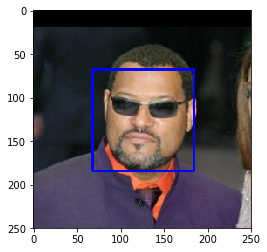

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_count=0
for file in human_files_short:
    if face_detector(file)>0: human_count += 1
print('Percentage of human face detected in human files: {}%'.format(human_count))

dog_count=0
for file in dog_files_short:
    if face_detector(file)>0: dog_count += 1 
print('Percentage of human face detected in dog files: {}%'.format(dog_count))

Percentage of human face detected in human files: 99%
Percentage of human face detected in dog files: 12%


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face? 

__Answer:__ It should do more, like identify a human on a photo of the whole human body with some mask on its head. A human should be identified by some of its body parts.

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [ ]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [6]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [8]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [10]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_count=0
for file in human_files_short:
    if dog_detector(file): human_count += 1
print('Percentage of dog detected in human files: {}%'.format(human_count))

dog_count=0
for file in dog_files_short:
    if dog_detector(file): dog_count += 1 
print('Percentage of dog detected in dog files: {}%'.format(dog_count))

Percentage of dog detected in human files: 1%
Percentage of dog detected in dog files: 100%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|███████████████████████████████████████████████████████████████████████████████| 836/836 [00:05<00:00, 163.64it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

In [12]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

img_size = 224
kernel_size = 2
pool_size = 2
strides=1

### TODO: Define your architecture.
model = Sequential()
model.add(Conv2D(filters=16, strides = strides, kernel_size=kernel_size, padding='same', activation='relu', 
                        input_shape=(img_size, img_size, 3)))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Conv2D(filters=32, strides = strides, kernel_size=kernel_size, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Conv2D(filters=64, strides = strides, kernel_size=kernel_size, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [13]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [14]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 30

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/30


5660/6680 [========================>.....] - ETA: 5:03 - loss: 4.8979 - acc: 0.0000e+0 - ETA: 2:42 - loss: 4.8960 - acc: 0.0000e+0 - ETA: 1:53 - loss: 4.8953 - acc: 0.0000e+0 - ETA: 1:29 - loss: 4.8914 - acc: 0.0000e+0 - ETA: 1:14 - loss: 4.8891 - acc: 0.0000e+0 - ETA: 1:05 - loss: 4.8883 - acc: 0.0000e+0 - ETA: 58s - loss: 4.8884 - acc: 0.0000e+0 - ETA: 53s - loss: 4.8870 - acc: 0.0063   - ETA: 48s - loss: 4.8880 - acc: 0.00 - ETA: 45s - loss: 4.8896 - acc: 0.00 - ETA: 42s - loss: 4.8903 - acc: 0.00 - ETA: 40s - loss: 4.8904 - acc: 0.00 - ETA: 36s - loss: 4.8898 - acc: 0.00 - ETA: 33s - loss: 4.8876 - acc: 0.00 - ETA: 32s - loss: 4.8871 - acc: 0.00 - ETA: 30s - loss: 4.8881 - acc: 0.00 - ETA: 29s - loss: 4.8879 - acc: 0.00 - ETA: 28s - loss: 4.8877 - acc: 0.00 - ETA: 28s - loss: 4.8873 - acc: 0.00 - ETA: 27s - loss: 4.8881 - acc: 0.00 - ETA: 27s - loss: 4.8875 - acc: 0.00 - ETA: 25s - loss: 4.8884 - acc: 0.00 - ETA: 25s - loss: 4.8878 - acc: 0.00 - ETA: 24s - loss: 4.8873 - acc: 0.00 

6680/6680 [==============================] - 21s 3ms/step - loss: 4.8834 - acc: 0.0081 - val_loss: 4.8677 - val_acc: 0.0168
Epoch 2/30


5460/6680 [=======================>......] - ETA: 15s - loss: 4.8984 - acc: 0.0000e+ - ETA: 15s - loss: 4.8793 - acc: 0.0167   - ETA: 15s - loss: 4.8692 - acc: 0.02 - ETA: 16s - loss: 4.8645 - acc: 0.03 - ETA: 16s - loss: 4.8488 - acc: 0.03 - ETA: 16s - loss: 4.8581 - acc: 0.02 - ETA: 16s - loss: 4.8616 - acc: 0.02 - ETA: 16s - loss: 4.8626 - acc: 0.02 - ETA: 16s - loss: 4.8642 - acc: 0.02 - ETA: 16s - loss: 4.8706 - acc: 0.01 - ETA: 16s - loss: 4.8702 - acc: 0.01 - ETA: 16s - loss: 4.8700 - acc: 0.01 - ETA: 15s - loss: 4.8675 - acc: 0.02 - ETA: 15s - loss: 4.8733 - acc: 0.02 - ETA: 15s - loss: 4.8742 - acc: 0.01 - ETA: 15s - loss: 4.8737 - acc: 0.01 - ETA: 15s - loss: 4.8695 - acc: 0.02 - ETA: 15s - loss: 4.8672 - acc: 0.01 - ETA: 15s - loss: 4.8613 - acc: 0.02 - ETA: 15s - loss: 4.8614 - acc: 0.01 - ETA: 15s - loss: 4.8616 - acc: 0.02 - ETA: 14s - loss: 4.8651 - acc: 0.02 - ETA: 14s - loss: 4.8629 - acc: 0.02 - ETA: 14s - loss: 4.8603 - acc: 0.02 - ETA: 14s - loss: 4.8610 - acc: 0.02

6680/6680 [==============================] - 18s 3ms/step - loss: 4.8547 - acc: 0.0169 - val_loss: 4.8377 - val_acc: 0.0192
Epoch 3/30


5820/6680 [=========================>....] - ETA: 15s - loss: 4.8212 - acc: 0.0000e+ - ETA: 16s - loss: 4.8239 - acc: 0.0000e+ - ETA: 16s - loss: 4.7928 - acc: 0.0000e+ - ETA: 17s - loss: 4.7965 - acc: 0.0000e+ - ETA: 17s - loss: 4.7945 - acc: 0.0167   - ETA: 16s - loss: 4.8186 - acc: 0.02 - ETA: 16s - loss: 4.8251 - acc: 0.02 - ETA: 16s - loss: 4.8178 - acc: 0.02 - ETA: 16s - loss: 4.8119 - acc: 0.02 - ETA: 16s - loss: 4.8167 - acc: 0.01 - ETA: 15s - loss: 4.8233 - acc: 0.02 - ETA: 15s - loss: 4.8260 - acc: 0.01 - ETA: 15s - loss: 4.8303 - acc: 0.01 - ETA: 15s - loss: 4.8248 - acc: 0.01 - ETA: 15s - loss: 4.8225 - acc: 0.01 - ETA: 15s - loss: 4.8226 - acc: 0.01 - ETA: 15s - loss: 4.8281 - acc: 0.01 - ETA: 15s - loss: 4.8302 - acc: 0.01 - ETA: 14s - loss: 4.8314 - acc: 0.01 - ETA: 14s - loss: 4.8300 - acc: 0.01 - ETA: 14s - loss: 4.8262 - acc: 0.01 - ETA: 14s - loss: 4.8260 - acc: 0.01 - ETA: 14s - loss: 4.8270 - acc: 0.01 - ETA: 14s - loss: 4.8267 - acc: 0.01 - ETA: 14s - loss: 4.8224

6680/6680 [==============================] - 18s 3ms/step - loss: 4.8160 - acc: 0.0174 - val_loss: 4.8229 - val_acc: 0.0156
Epoch 4/30


5220/6680 [======================>.......] - ETA: 15s - loss: 4.7266 - acc: 0.0000e+ - ETA: 15s - loss: 4.7421 - acc: 0.0167   - ETA: 16s - loss: 4.7271 - acc: 0.01 - ETA: 16s - loss: 4.7029 - acc: 0.00 - ETA: 16s - loss: 4.7261 - acc: 0.00 - ETA: 16s - loss: 4.7247 - acc: 0.01 - ETA: 16s - loss: 4.7285 - acc: 0.01 - ETA: 16s - loss: 4.7446 - acc: 0.01 - ETA: 16s - loss: 4.7555 - acc: 0.01 - ETA: 15s - loss: 4.7535 - acc: 0.01 - ETA: 16s - loss: 4.7632 - acc: 0.01 - ETA: 16s - loss: 4.7592 - acc: 0.01 - ETA: 16s - loss: 4.7574 - acc: 0.01 - ETA: 16s - loss: 4.7626 - acc: 0.01 - ETA: 16s - loss: 4.7654 - acc: 0.01 - ETA: 15s - loss: 4.7576 - acc: 0.01 - ETA: 15s - loss: 4.7592 - acc: 0.01 - ETA: 15s - loss: 4.7591 - acc: 0.01 - ETA: 15s - loss: 4.7602 - acc: 0.01 - ETA: 15s - loss: 4.7568 - acc: 0.01 - ETA: 15s - loss: 4.7621 - acc: 0.01 - ETA: 15s - loss: 4.7645 - acc: 0.01 - ETA: 15s - loss: 4.7627 - acc: 0.01 - ETA: 15s - loss: 4.7649 - acc: 0.01 - ETA: 15s - loss: 4.7659 - acc: 0.01

6680/6680 [==============================] - 18s 3ms/step - loss: 4.7876 - acc: 0.0159 - val_loss: 4.8020 - val_acc: 0.0180
Epoch 5/30


5520/6680 [=======================>......] - ETA: 14s - loss: 4.5766 - acc: 0.0000e+ - ETA: 15s - loss: 4.6574 - acc: 0.0250   - ETA: 15s - loss: 4.7538 - acc: 0.02 - ETA: 14s - loss: 4.7450 - acc: 0.01 - ETA: 15s - loss: 4.7384 - acc: 0.01 - ETA: 15s - loss: 4.7475 - acc: 0.01 - ETA: 15s - loss: 4.7399 - acc: 0.01 - ETA: 15s - loss: 4.7484 - acc: 0.01 - ETA: 15s - loss: 4.7573 - acc: 0.01 - ETA: 15s - loss: 4.7664 - acc: 0.01 - ETA: 15s - loss: 4.7716 - acc: 0.01 - ETA: 15s - loss: 4.7662 - acc: 0.00 - ETA: 15s - loss: 4.7622 - acc: 0.01 - ETA: 15s - loss: 4.7839 - acc: 0.01 - ETA: 15s - loss: 4.7906 - acc: 0.01 - ETA: 15s - loss: 4.7874 - acc: 0.00 - ETA: 15s - loss: 4.7857 - acc: 0.01 - ETA: 15s - loss: 4.7799 - acc: 0.01 - ETA: 15s - loss: 4.7875 - acc: 0.01 - ETA: 15s - loss: 4.7852 - acc: 0.01 - ETA: 15s - loss: 4.7800 - acc: 0.01 - ETA: 14s - loss: 4.7860 - acc: 0.01 - ETA: 14s - loss: 4.7835 - acc: 0.01 - ETA: 14s - loss: 4.7907 - acc: 0.01 - ETA: 14s - loss: 4.7863 - acc: 0.01

6680/6680 [==============================] - 18s 3ms/step - loss: 4.7661 - acc: 0.0211 - val_loss: 4.7852 - val_acc: 0.0228
Epoch 6/30


5360/6680 [=======================>......] - ETA: 15s - loss: 4.9127 - acc: 0.0000e+ - ETA: 16s - loss: 4.8553 - acc: 0.0000e+ - ETA: 16s - loss: 4.7936 - acc: 0.0000e+ - ETA: 16s - loss: 4.7886 - acc: 0.0000e+ - ETA: 16s - loss: 4.7722 - acc: 0.0000e+ - ETA: 16s - loss: 4.7600 - acc: 0.0083   - ETA: 16s - loss: 4.7799 - acc: 0.00 - ETA: 16s - loss: 4.7615 - acc: 0.01 - ETA: 15s - loss: 4.7574 - acc: 0.01 - ETA: 16s - loss: 4.7501 - acc: 0.01 - ETA: 16s - loss: 4.7394 - acc: 0.01 - ETA: 16s - loss: 4.7529 - acc: 0.01 - ETA: 15s - loss: 4.7685 - acc: 0.01 - ETA: 16s - loss: 4.7683 - acc: 0.01 - ETA: 15s - loss: 4.7735 - acc: 0.01 - ETA: 16s - loss: 4.7721 - acc: 0.02 - ETA: 16s - loss: 4.7632 - acc: 0.02 - ETA: 15s - loss: 4.7597 - acc: 0.01 - ETA: 15s - loss: 4.7542 - acc: 0.01 - ETA: 15s - loss: 4.7540 - acc: 0.01 - ETA: 15s - loss: 4.7616 - acc: 0.02 - ETA: 15s - loss: 4.7560 - acc: 0.01 - ETA: 15s - loss: 4.7516 - acc: 0.02 - ETA: 15s - loss: 4.7523 - acc: 0.02 - ETA: 15s - loss: 4.

6680/6680 [==============================] - 18s 3ms/step - loss: 4.7415 - acc: 0.0226 - val_loss: 4.7578 - val_acc: 0.0204
Epoch 7/30


5420/6680 [=======================>......] - ETA: 15s - loss: 4.8627 - acc: 0.0000e+ - ETA: 16s - loss: 4.7849 - acc: 0.0250   - ETA: 16s - loss: 4.7590 - acc: 0.03 - ETA: 16s - loss: 4.7425 - acc: 0.02 - ETA: 16s - loss: 4.7635 - acc: 0.02 - ETA: 16s - loss: 4.8008 - acc: 0.01 - ETA: 16s - loss: 4.7827 - acc: 0.01 - ETA: 15s - loss: 4.7613 - acc: 0.02 - ETA: 15s - loss: 4.7586 - acc: 0.02 - ETA: 15s - loss: 4.7447 - acc: 0.02 - ETA: 15s - loss: 4.7488 - acc: 0.02 - ETA: 15s - loss: 4.7584 - acc: 0.02 - ETA: 15s - loss: 4.7635 - acc: 0.02 - ETA: 15s - loss: 4.7590 - acc: 0.02 - ETA: 15s - loss: 4.7572 - acc: 0.02 - ETA: 15s - loss: 4.7644 - acc: 0.02 - ETA: 14s - loss: 4.7541 - acc: 0.02 - ETA: 15s - loss: 4.7476 - acc: 0.02 - ETA: 15s - loss: 4.7373 - acc: 0.02 - ETA: 15s - loss: 4.7418 - acc: 0.02 - ETA: 14s - loss: 4.7369 - acc: 0.02 - ETA: 14s - loss: 4.7337 - acc: 0.02 - ETA: 14s - loss: 4.7251 - acc: 0.02 - ETA: 14s - loss: 4.7273 - acc: 0.02 - ETA: 14s - loss: 4.7317 - acc: 0.02

6680/6680 [==============================] - 18s 3ms/step - loss: 4.7113 - acc: 0.0238 - val_loss: 4.7411 - val_acc: 0.0251
Epoch 8/30


5340/6680 [======================>.......] - ETA: 15s - loss: 5.0214 - acc: 0.0000e+ - ETA: 14s - loss: 4.8194 - acc: 0.0667   - ETA: 15s - loss: 4.7554 - acc: 0.06 - ETA: 16s - loss: 4.7835 - acc: 0.05 - ETA: 16s - loss: 4.7991 - acc: 0.04 - ETA: 15s - loss: 4.7965 - acc: 0.03 - ETA: 15s - loss: 4.7850 - acc: 0.03 - ETA: 15s - loss: 4.7666 - acc: 0.03 - ETA: 15s - loss: 4.7602 - acc: 0.02 - ETA: 15s - loss: 4.7308 - acc: 0.02 - ETA: 15s - loss: 4.7402 - acc: 0.02 - ETA: 15s - loss: 4.7212 - acc: 0.03 - ETA: 15s - loss: 4.7209 - acc: 0.03 - ETA: 15s - loss: 4.7159 - acc: 0.03 - ETA: 15s - loss: 4.7065 - acc: 0.03 - ETA: 15s - loss: 4.6921 - acc: 0.03 - ETA: 15s - loss: 4.6667 - acc: 0.04 - ETA: 15s - loss: 4.6717 - acc: 0.04 - ETA: 15s - loss: 4.6732 - acc: 0.04 - ETA: 15s - loss: 4.6637 - acc: 0.04 - ETA: 15s - loss: 4.6582 - acc: 0.04 - ETA: 14s - loss: 4.6522 - acc: 0.04 - ETA: 15s - loss: 4.6541 - acc: 0.04 - ETA: 15s - loss: 4.6496 - acc: 0.04 - ETA: 14s - loss: 4.6443 - acc: 0.04

6680/6680 [==============================] - 18s 3ms/step - loss: 4.6858 - acc: 0.0295 - val_loss: 4.7368 - val_acc: 0.0240
Epoch 9/30


5140/6680 [======================>.......] - ETA: 15s - loss: 4.7620 - acc: 0.05 - ETA: 16s - loss: 4.7151 - acc: 0.05 - ETA: 16s - loss: 4.7544 - acc: 0.03 - ETA: 15s - loss: 4.7540 - acc: 0.03 - ETA: 16s - loss: 4.7859 - acc: 0.02 - ETA: 16s - loss: 4.7611 - acc: 0.03 - ETA: 16s - loss: 4.7379 - acc: 0.03 - ETA: 16s - loss: 4.7285 - acc: 0.03 - ETA: 16s - loss: 4.7213 - acc: 0.03 - ETA: 16s - loss: 4.7239 - acc: 0.02 - ETA: 16s - loss: 4.7274 - acc: 0.02 - ETA: 15s - loss: 4.7052 - acc: 0.03 - ETA: 15s - loss: 4.7015 - acc: 0.03 - ETA: 16s - loss: 4.7023 - acc: 0.03 - ETA: 16s - loss: 4.7111 - acc: 0.02 - ETA: 15s - loss: 4.7001 - acc: 0.03 - ETA: 15s - loss: 4.7052 - acc: 0.03 - ETA: 15s - loss: 4.7152 - acc: 0.03 - ETA: 15s - loss: 4.7090 - acc: 0.03 - ETA: 15s - loss: 4.7059 - acc: 0.03 - ETA: 15s - loss: 4.7031 - acc: 0.03 - ETA: 15s - loss: 4.7018 - acc: 0.03 - ETA: 15s - loss: 4.6991 - acc: 0.03 - ETA: 15s - loss: 4.7010 - acc: 0.03 - ETA: 15s - loss: 4.6986 - acc: 0.03 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 4.6613 - acc: 0.0325 - val_loss: 4.7144 - val_acc: 0.0287
Epoch 10/30


5200/6680 [======================>.......] - ETA: 15s - loss: 4.3919 - acc: 0.05 - ETA: 16s - loss: 4.4450 - acc: 0.05 - ETA: 16s - loss: 4.4646 - acc: 0.05 - ETA: 16s - loss: 4.5837 - acc: 0.05 - ETA: 16s - loss: 4.5968 - acc: 0.05 - ETA: 16s - loss: 4.6521 - acc: 0.04 - ETA: 16s - loss: 4.6289 - acc: 0.03 - ETA: 15s - loss: 4.6173 - acc: 0.04 - ETA: 16s - loss: 4.6030 - acc: 0.04 - ETA: 16s - loss: 4.6049 - acc: 0.04 - ETA: 16s - loss: 4.5889 - acc: 0.04 - ETA: 16s - loss: 4.5970 - acc: 0.04 - ETA: 16s - loss: 4.6195 - acc: 0.04 - ETA: 16s - loss: 4.6168 - acc: 0.04 - ETA: 16s - loss: 4.6084 - acc: 0.04 - ETA: 16s - loss: 4.5942 - acc: 0.03 - ETA: 16s - loss: 4.5940 - acc: 0.03 - ETA: 15s - loss: 4.6073 - acc: 0.03 - ETA: 15s - loss: 4.6051 - acc: 0.03 - ETA: 15s - loss: 4.6179 - acc: 0.03 - ETA: 15s - loss: 4.6202 - acc: 0.03 - ETA: 15s - loss: 4.6129 - acc: 0.03 - ETA: 15s - loss: 4.6249 - acc: 0.03 - ETA: 15s - loss: 4.6260 - acc: 0.03 - ETA: 15s - loss: 4.6222 - acc: 0.03 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 4.6402 - acc: 0.0359 - val_loss: 4.6920 - val_acc: 0.0311
Epoch 11/30


5220/6680 [======================>.......] - ETA: 16s - loss: 4.4383 - acc: 0.05 - ETA: 16s - loss: 4.3977 - acc: 0.05 - ETA: 16s - loss: 4.4620 - acc: 0.03 - ETA: 16s - loss: 4.4733 - acc: 0.03 - ETA: 16s - loss: 4.5092 - acc: 0.03 - ETA: 16s - loss: 4.4996 - acc: 0.02 - ETA: 16s - loss: 4.4823 - acc: 0.03 - ETA: 16s - loss: 4.5188 - acc: 0.03 - ETA: 16s - loss: 4.5383 - acc: 0.03 - ETA: 16s - loss: 4.5778 - acc: 0.03 - ETA: 16s - loss: 4.5927 - acc: 0.03 - ETA: 16s - loss: 4.6205 - acc: 0.02 - ETA: 16s - loss: 4.6210 - acc: 0.03 - ETA: 16s - loss: 4.6118 - acc: 0.03 - ETA: 16s - loss: 4.6118 - acc: 0.03 - ETA: 16s - loss: 4.6091 - acc: 0.02 - ETA: 16s - loss: 4.6312 - acc: 0.02 - ETA: 15s - loss: 4.6251 - acc: 0.03 - ETA: 15s - loss: 4.6283 - acc: 0.03 - ETA: 15s - loss: 4.6198 - acc: 0.03 - ETA: 15s - loss: 4.6193 - acc: 0.02 - ETA: 15s - loss: 4.6115 - acc: 0.03 - ETA: 15s - loss: 4.6089 - acc: 0.03 - ETA: 15s - loss: 4.5993 - acc: 0.03 - ETA: 15s - loss: 4.5974 - acc: 0.03 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 4.6169 - acc: 0.0380 - val_loss: 4.6710 - val_acc: 0.0347
Epoch 12/30


5540/6680 [=======================>......] - ETA: 15s - loss: 4.7606 - acc: 0.0000e+ - ETA: 14s - loss: 4.6777 - acc: 0.0500   - ETA: 15s - loss: 4.6414 - acc: 0.05 - ETA: 15s - loss: 4.5927 - acc: 0.05 - ETA: 15s - loss: 4.6254 - acc: 0.04 - ETA: 16s - loss: 4.6103 - acc: 0.04 - ETA: 16s - loss: 4.5911 - acc: 0.05 - ETA: 15s - loss: 4.5774 - acc: 0.05 - ETA: 15s - loss: 4.5817 - acc: 0.05 - ETA: 15s - loss: 4.5566 - acc: 0.05 - ETA: 15s - loss: 4.5553 - acc: 0.04 - ETA: 15s - loss: 4.5483 - acc: 0.04 - ETA: 15s - loss: 4.5724 - acc: 0.04 - ETA: 15s - loss: 4.5860 - acc: 0.04 - ETA: 15s - loss: 4.5759 - acc: 0.03 - ETA: 15s - loss: 4.5787 - acc: 0.04 - ETA: 15s - loss: 4.5706 - acc: 0.03 - ETA: 15s - loss: 4.5703 - acc: 0.04 - ETA: 15s - loss: 4.5578 - acc: 0.03 - ETA: 15s - loss: 4.5477 - acc: 0.04 - ETA: 15s - loss: 4.5672 - acc: 0.04 - ETA: 15s - loss: 4.5621 - acc: 0.04 - ETA: 15s - loss: 4.5597 - acc: 0.04 - ETA: 15s - loss: 4.5614 - acc: 0.04 - ETA: 15s - loss: 4.5671 - acc: 0.04

6680/6680 [==============================] - 18s 3ms/step - loss: 4.5973 - acc: 0.0386 - val_loss: 4.6579 - val_acc: 0.0335
Epoch 13/30


5280/6680 [======================>.......] - ETA: 16s - loss: 4.5078 - acc: 0.05 - ETA: 16s - loss: 4.4203 - acc: 0.07 - ETA: 17s - loss: 4.5094 - acc: 0.05 - ETA: 16s - loss: 4.5988 - acc: 0.03 - ETA: 17s - loss: 4.6204 - acc: 0.04 - ETA: 17s - loss: 4.5981 - acc: 0.04 - ETA: 17s - loss: 4.6228 - acc: 0.03 - ETA: 17s - loss: 4.5912 - acc: 0.03 - ETA: 16s - loss: 4.6232 - acc: 0.03 - ETA: 16s - loss: 4.6225 - acc: 0.03 - ETA: 16s - loss: 4.6070 - acc: 0.03 - ETA: 16s - loss: 4.5909 - acc: 0.04 - ETA: 16s - loss: 4.6397 - acc: 0.04 - ETA: 16s - loss: 4.6411 - acc: 0.04 - ETA: 16s - loss: 4.6384 - acc: 0.04 - ETA: 16s - loss: 4.6369 - acc: 0.03 - ETA: 16s - loss: 4.6260 - acc: 0.04 - ETA: 16s - loss: 4.6366 - acc: 0.04 - ETA: 16s - loss: 4.6253 - acc: 0.04 - ETA: 16s - loss: 4.6154 - acc: 0.04 - ETA: 16s - loss: 4.6139 - acc: 0.04 - ETA: 16s - loss: 4.6173 - acc: 0.04 - ETA: 16s - loss: 4.6095 - acc: 0.04 - ETA: 16s - loss: 4.6054 - acc: 0.04 - ETA: 16s - loss: 4.6035 - acc: 0.04 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 4.5770 - acc: 0.0415 - val_loss: 4.6490 - val_acc: 0.0347
Epoch 14/30


5580/6680 [========================>.....] - ETA: 15s - loss: 4.4435 - acc: 0.10 - ETA: 15s - loss: 4.5787 - acc: 0.05 - ETA: 16s - loss: 4.5743 - acc: 0.05 - ETA: 15s - loss: 4.5831 - acc: 0.04 - ETA: 16s - loss: 4.5967 - acc: 0.04 - ETA: 15s - loss: 4.5465 - acc: 0.05 - ETA: 15s - loss: 4.5471 - acc: 0.05 - ETA: 16s - loss: 4.5455 - acc: 0.05 - ETA: 15s - loss: 4.5238 - acc: 0.05 - ETA: 15s - loss: 4.5269 - acc: 0.05 - ETA: 15s - loss: 4.5394 - acc: 0.05 - ETA: 15s - loss: 4.5300 - acc: 0.05 - ETA: 15s - loss: 4.5430 - acc: 0.05 - ETA: 15s - loss: 4.5341 - acc: 0.04 - ETA: 15s - loss: 4.5207 - acc: 0.04 - ETA: 15s - loss: 4.5251 - acc: 0.05 - ETA: 15s - loss: 4.5246 - acc: 0.04 - ETA: 15s - loss: 4.5211 - acc: 0.04 - ETA: 15s - loss: 4.5207 - acc: 0.04 - ETA: 15s - loss: 4.5364 - acc: 0.04 - ETA: 15s - loss: 4.5338 - acc: 0.04 - ETA: 15s - loss: 4.5338 - acc: 0.04 - ETA: 15s - loss: 4.5360 - acc: 0.04 - ETA: 15s - loss: 4.5342 - acc: 0.04 - ETA: 15s - loss: 4.5350 - acc: 0.04 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 4.5565 - acc: 0.0439 - val_loss: 4.6273 - val_acc: 0.0359
Epoch 15/30


5760/6680 [========================>.....] - ETA: 15s - loss: 4.6068 - acc: 0.05 - ETA: 15s - loss: 4.5095 - acc: 0.01 - ETA: 15s - loss: 4.5246 - acc: 0.01 - ETA: 16s - loss: 4.5430 - acc: 0.02 - ETA: 15s - loss: 4.4974 - acc: 0.02 - ETA: 15s - loss: 4.5309 - acc: 0.01 - ETA: 15s - loss: 4.4984 - acc: 0.03 - ETA: 15s - loss: 4.5162 - acc: 0.03 - ETA: 15s - loss: 4.5506 - acc: 0.03 - ETA: 15s - loss: 4.5570 - acc: 0.02 - ETA: 15s - loss: 4.5303 - acc: 0.03 - ETA: 15s - loss: 4.5246 - acc: 0.03 - ETA: 15s - loss: 4.5203 - acc: 0.03 - ETA: 15s - loss: 4.5287 - acc: 0.04 - ETA: 15s - loss: 4.5315 - acc: 0.04 - ETA: 15s - loss: 4.5322 - acc: 0.04 - ETA: 15s - loss: 4.5313 - acc: 0.04 - ETA: 15s - loss: 4.5218 - acc: 0.04 - ETA: 15s - loss: 4.5315 - acc: 0.04 - ETA: 15s - loss: 4.5442 - acc: 0.04 - ETA: 15s - loss: 4.5378 - acc: 0.04 - ETA: 15s - loss: 4.5445 - acc: 0.04 - ETA: 15s - loss: 4.5448 - acc: 0.04 - ETA: 15s - loss: 4.5318 - acc: 0.04 - ETA: 15s - loss: 4.5352 - acc: 0.04 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 4.5321 - acc: 0.0478 - val_loss: 4.6378 - val_acc: 0.0347
Epoch 16/30


5700/6680 [========================>.....] - ETA: 15s - loss: 4.3137 - acc: 0.05 - ETA: 15s - loss: 4.3472 - acc: 0.07 - ETA: 16s - loss: 4.4360 - acc: 0.06 - ETA: 16s - loss: 4.4842 - acc: 0.06 - ETA: 17s - loss: 4.5210 - acc: 0.05 - ETA: 16s - loss: 4.4842 - acc: 0.06 - ETA: 16s - loss: 4.4890 - acc: 0.06 - ETA: 16s - loss: 4.5120 - acc: 0.05 - ETA: 16s - loss: 4.5291 - acc: 0.05 - ETA: 16s - loss: 4.5304 - acc: 0.05 - ETA: 16s - loss: 4.5339 - acc: 0.04 - ETA: 16s - loss: 4.5463 - acc: 0.04 - ETA: 15s - loss: 4.5413 - acc: 0.03 - ETA: 16s - loss: 4.5505 - acc: 0.03 - ETA: 15s - loss: 4.5214 - acc: 0.03 - ETA: 15s - loss: 4.5273 - acc: 0.03 - ETA: 15s - loss: 4.5175 - acc: 0.03 - ETA: 15s - loss: 4.5128 - acc: 0.03 - ETA: 15s - loss: 4.5019 - acc: 0.03 - ETA: 15s - loss: 4.5018 - acc: 0.03 - ETA: 15s - loss: 4.5135 - acc: 0.03 - ETA: 15s - loss: 4.5173 - acc: 0.03 - ETA: 15s - loss: 4.5181 - acc: 0.03 - ETA: 15s - loss: 4.5039 - acc: 0.03 - ETA: 15s - loss: 4.4937 - acc: 0.03 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 4.5112 - acc: 0.0451 - val_loss: 4.6228 - val_acc: 0.0419
Epoch 17/30


5680/6680 [========================>.....] - ETA: 16s - loss: 4.6003 - acc: 0.0000e+ - ETA: 15s - loss: 4.4484 - acc: 0.0333   - ETA: 16s - loss: 4.5039 - acc: 0.03 - ETA: 16s - loss: 4.5169 - acc: 0.03 - ETA: 16s - loss: 4.5051 - acc: 0.02 - ETA: 16s - loss: 4.5258 - acc: 0.02 - ETA: 16s - loss: 4.5173 - acc: 0.02 - ETA: 16s - loss: 4.4961 - acc: 0.04 - ETA: 15s - loss: 4.4755 - acc: 0.03 - ETA: 15s - loss: 4.4729 - acc: 0.03 - ETA: 15s - loss: 4.4911 - acc: 0.04 - ETA: 15s - loss: 4.4924 - acc: 0.04 - ETA: 15s - loss: 4.4836 - acc: 0.03 - ETA: 15s - loss: 4.4787 - acc: 0.03 - ETA: 15s - loss: 4.4636 - acc: 0.04 - ETA: 15s - loss: 4.4596 - acc: 0.04 - ETA: 15s - loss: 4.4856 - acc: 0.03 - ETA: 15s - loss: 4.4919 - acc: 0.03 - ETA: 15s - loss: 4.4990 - acc: 0.04 - ETA: 15s - loss: 4.4989 - acc: 0.03 - ETA: 14s - loss: 4.5105 - acc: 0.03 - ETA: 14s - loss: 4.5142 - acc: 0.03 - ETA: 14s - loss: 4.5178 - acc: 0.03 - ETA: 14s - loss: 4.5208 - acc: 0.03 - ETA: 14s - loss: 4.5187 - acc: 0.03

6680/6680 [==============================] - 18s 3ms/step - loss: 4.4906 - acc: 0.0481 - val_loss: 4.5819 - val_acc: 0.0383
Epoch 18/30


5440/6680 [=======================>......] - ETA: 15s - loss: 4.4401 - acc: 0.05 - ETA: 14s - loss: 4.4275 - acc: 0.05 - ETA: 16s - loss: 4.4916 - acc: 0.03 - ETA: 15s - loss: 4.5809 - acc: 0.04 - ETA: 15s - loss: 4.5174 - acc: 0.04 - ETA: 15s - loss: 4.5185 - acc: 0.03 - ETA: 15s - loss: 4.4991 - acc: 0.04 - ETA: 15s - loss: 4.4915 - acc: 0.04 - ETA: 16s - loss: 4.4684 - acc: 0.04 - ETA: 16s - loss: 4.4691 - acc: 0.04 - ETA: 15s - loss: 4.4535 - acc: 0.04 - ETA: 15s - loss: 4.4548 - acc: 0.04 - ETA: 15s - loss: 4.4548 - acc: 0.04 - ETA: 15s - loss: 4.4690 - acc: 0.04 - ETA: 15s - loss: 4.4627 - acc: 0.05 - ETA: 15s - loss: 4.4600 - acc: 0.05 - ETA: 15s - loss: 4.4453 - acc: 0.04 - ETA: 15s - loss: 4.4528 - acc: 0.04 - ETA: 15s - loss: 4.4472 - acc: 0.04 - ETA: 15s - loss: 4.4555 - acc: 0.04 - ETA: 15s - loss: 4.4528 - acc: 0.04 - ETA: 15s - loss: 4.4712 - acc: 0.04 - ETA: 15s - loss: 4.4712 - acc: 0.04 - ETA: 15s - loss: 4.4743 - acc: 0.04 - ETA: 15s - loss: 4.4759 - acc: 0.04 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 4.4712 - acc: 0.0519 - val_loss: 4.5785 - val_acc: 0.0347
Epoch 19/30


5640/6680 [========================>.....] - ETA: 15s - loss: 4.3290 - acc: 0.10 - ETA: 13s - loss: 4.3082 - acc: 0.10 - ETA: 15s - loss: 4.4192 - acc: 0.08 - ETA: 14s - loss: 4.3729 - acc: 0.08 - ETA: 15s - loss: 4.3760 - acc: 0.07 - ETA: 15s - loss: 4.3957 - acc: 0.06 - ETA: 15s - loss: 4.3980 - acc: 0.06 - ETA: 15s - loss: 4.3869 - acc: 0.05 - ETA: 15s - loss: 4.3896 - acc: 0.05 - ETA: 15s - loss: 4.4194 - acc: 0.05 - ETA: 15s - loss: 4.4236 - acc: 0.05 - ETA: 15s - loss: 4.4243 - acc: 0.05 - ETA: 15s - loss: 4.4282 - acc: 0.05 - ETA: 15s - loss: 4.4242 - acc: 0.05 - ETA: 15s - loss: 4.4170 - acc: 0.05 - ETA: 15s - loss: 4.3995 - acc: 0.05 - ETA: 15s - loss: 4.4135 - acc: 0.05 - ETA: 15s - loss: 4.4192 - acc: 0.05 - ETA: 15s - loss: 4.4174 - acc: 0.05 - ETA: 15s - loss: 4.4355 - acc: 0.05 - ETA: 15s - loss: 4.4410 - acc: 0.05 - ETA: 15s - loss: 4.4347 - acc: 0.05 - ETA: 15s - loss: 4.4378 - acc: 0.05 - ETA: 15s - loss: 4.4282 - acc: 0.05 - ETA: 14s - loss: 4.4180 - acc: 0.05 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 4.4487 - acc: 0.0548 - val_loss: 4.5660 - val_acc: 0.0407
Epoch 20/30


5720/6680 [========================>.....] - ETA: 15s - loss: 4.3072 - acc: 0.10 - ETA: 16s - loss: 4.4639 - acc: 0.03 - ETA: 16s - loss: 4.4158 - acc: 0.05 - ETA: 16s - loss: 4.4233 - acc: 0.05 - ETA: 16s - loss: 4.4611 - acc: 0.05 - ETA: 16s - loss: 4.4408 - acc: 0.05 - ETA: 16s - loss: 4.4500 - acc: 0.05 - ETA: 16s - loss: 4.4256 - acc: 0.05 - ETA: 15s - loss: 4.4073 - acc: 0.05 - ETA: 16s - loss: 4.4113 - acc: 0.05 - ETA: 16s - loss: 4.3934 - acc: 0.06 - ETA: 15s - loss: 4.3819 - acc: 0.05 - ETA: 15s - loss: 4.4137 - acc: 0.06 - ETA: 15s - loss: 4.4146 - acc: 0.06 - ETA: 15s - loss: 4.4126 - acc: 0.06 - ETA: 15s - loss: 4.4156 - acc: 0.06 - ETA: 15s - loss: 4.4178 - acc: 0.07 - ETA: 15s - loss: 4.4146 - acc: 0.07 - ETA: 15s - loss: 4.4142 - acc: 0.07 - ETA: 15s - loss: 4.4195 - acc: 0.07 - ETA: 15s - loss: 4.4150 - acc: 0.07 - ETA: 15s - loss: 4.4200 - acc: 0.07 - ETA: 14s - loss: 4.4133 - acc: 0.07 - ETA: 15s - loss: 4.4127 - acc: 0.07 - ETA: 15s - loss: 4.4203 - acc: 0.06 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 4.4308 - acc: 0.0575 - val_loss: 4.5571 - val_acc: 0.0395
Epoch 21/30


5740/6680 [========================>.....] - ETA: 16s - loss: 4.1742 - acc: 0.05 - ETA: 14s - loss: 4.2141 - acc: 0.05 - ETA: 15s - loss: 4.2410 - acc: 0.05 - ETA: 16s - loss: 4.2545 - acc: 0.04 - ETA: 16s - loss: 4.3144 - acc: 0.05 - ETA: 16s - loss: 4.3031 - acc: 0.05 - ETA: 15s - loss: 4.3455 - acc: 0.05 - ETA: 15s - loss: 4.3484 - acc: 0.05 - ETA: 15s - loss: 4.3618 - acc: 0.05 - ETA: 15s - loss: 4.3647 - acc: 0.05 - ETA: 15s - loss: 4.3621 - acc: 0.05 - ETA: 15s - loss: 4.3676 - acc: 0.04 - ETA: 15s - loss: 4.3664 - acc: 0.05 - ETA: 15s - loss: 4.3539 - acc: 0.05 - ETA: 15s - loss: 4.3774 - acc: 0.05 - ETA: 15s - loss: 4.3571 - acc: 0.05 - ETA: 15s - loss: 4.3529 - acc: 0.05 - ETA: 15s - loss: 4.3783 - acc: 0.05 - ETA: 15s - loss: 4.3709 - acc: 0.05 - ETA: 15s - loss: 4.3764 - acc: 0.05 - ETA: 14s - loss: 4.3858 - acc: 0.05 - ETA: 15s - loss: 4.3840 - acc: 0.05 - ETA: 15s - loss: 4.3830 - acc: 0.05 - ETA: 14s - loss: 4.3926 - acc: 0.05 - ETA: 14s - loss: 4.4010 - acc: 0.05 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 4.4116 - acc: 0.0570 - val_loss: 4.5727 - val_acc: 0.0347
Epoch 22/30


5680/6680 [========================>.....] - ETA: 15s - loss: 4.7313 - acc: 0.0000e+ - ETA: 16s - loss: 4.4369 - acc: 0.0500   - ETA: 14s - loss: 4.4273 - acc: 0.07 - ETA: 15s - loss: 4.4455 - acc: 0.06 - ETA: 15s - loss: 4.4335 - acc: 0.05 - ETA: 16s - loss: 4.4212 - acc: 0.05 - ETA: 16s - loss: 4.4047 - acc: 0.05 - ETA: 16s - loss: 4.4275 - acc: 0.05 - ETA: 16s - loss: 4.4014 - acc: 0.06 - ETA: 15s - loss: 4.4299 - acc: 0.05 - ETA: 16s - loss: 4.4066 - acc: 0.06 - ETA: 16s - loss: 4.4227 - acc: 0.05 - ETA: 15s - loss: 4.4339 - acc: 0.05 - ETA: 15s - loss: 4.4125 - acc: 0.05 - ETA: 15s - loss: 4.4188 - acc: 0.05 - ETA: 15s - loss: 4.4261 - acc: 0.05 - ETA: 15s - loss: 4.4055 - acc: 0.05 - ETA: 15s - loss: 4.3934 - acc: 0.05 - ETA: 15s - loss: 4.4121 - acc: 0.05 - ETA: 15s - loss: 4.4091 - acc: 0.05 - ETA: 15s - loss: 4.4075 - acc: 0.05 - ETA: 15s - loss: 4.4013 - acc: 0.05 - ETA: 15s - loss: 4.3898 - acc: 0.05 - ETA: 15s - loss: 4.3844 - acc: 0.05 - ETA: 15s - loss: 4.3821 - acc: 0.05

6680/6680 [==============================] - 18s 3ms/step - loss: 4.3938 - acc: 0.0600 - val_loss: 4.5380 - val_acc: 0.0383
Epoch 23/30


5580/6680 [========================>.....] - ETA: 15s - loss: 4.5602 - acc: 0.05 - ETA: 15s - loss: 4.5122 - acc: 0.10 - ETA: 15s - loss: 4.3517 - acc: 0.08 - ETA: 15s - loss: 4.3723 - acc: 0.07 - ETA: 15s - loss: 4.3711 - acc: 0.05 - ETA: 15s - loss: 4.3864 - acc: 0.04 - ETA: 15s - loss: 4.3480 - acc: 0.05 - ETA: 16s - loss: 4.3468 - acc: 0.05 - ETA: 15s - loss: 4.3467 - acc: 0.05 - ETA: 15s - loss: 4.3416 - acc: 0.04 - ETA: 15s - loss: 4.3253 - acc: 0.05 - ETA: 15s - loss: 4.3311 - acc: 0.05 - ETA: 15s - loss: 4.3193 - acc: 0.05 - ETA: 15s - loss: 4.3202 - acc: 0.05 - ETA: 15s - loss: 4.3226 - acc: 0.05 - ETA: 15s - loss: 4.3112 - acc: 0.05 - ETA: 15s - loss: 4.3127 - acc: 0.05 - ETA: 15s - loss: 4.3166 - acc: 0.05 - ETA: 15s - loss: 4.3067 - acc: 0.05 - ETA: 15s - loss: 4.2954 - acc: 0.05 - ETA: 15s - loss: 4.2996 - acc: 0.05 - ETA: 15s - loss: 4.3155 - acc: 0.06 - ETA: 15s - loss: 4.3176 - acc: 0.05 - ETA: 14s - loss: 4.3282 - acc: 0.06 - ETA: 15s - loss: 4.3234 - acc: 0.06 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 4.3705 - acc: 0.0605 - val_loss: 4.5599 - val_acc: 0.0395
Epoch 24/30


5820/6680 [=========================>....] - ETA: 15s - loss: 4.6475 - acc: 0.0000e+ - ETA: 15s - loss: 4.5591 - acc: 0.0500   - ETA: 15s - loss: 4.5378 - acc: 0.05 - ETA: 15s - loss: 4.5083 - acc: 0.05 - ETA: 16s - loss: 4.5199 - acc: 0.04 - ETA: 16s - loss: 4.4509 - acc: 0.05 - ETA: 15s - loss: 4.4976 - acc: 0.05 - ETA: 16s - loss: 4.4777 - acc: 0.04 - ETA: 16s - loss: 4.4647 - acc: 0.05 - ETA: 15s - loss: 4.4785 - acc: 0.04 - ETA: 15s - loss: 4.4840 - acc: 0.03 - ETA: 15s - loss: 4.4454 - acc: 0.04 - ETA: 15s - loss: 4.4299 - acc: 0.03 - ETA: 15s - loss: 4.4300 - acc: 0.03 - ETA: 15s - loss: 4.4236 - acc: 0.04 - ETA: 15s - loss: 4.4115 - acc: 0.03 - ETA: 15s - loss: 4.3948 - acc: 0.04 - ETA: 15s - loss: 4.3906 - acc: 0.04 - ETA: 15s - loss: 4.3819 - acc: 0.04 - ETA: 15s - loss: 4.3834 - acc: 0.04 - ETA: 14s - loss: 4.3949 - acc: 0.04 - ETA: 15s - loss: 4.3870 - acc: 0.04 - ETA: 14s - loss: 4.3957 - acc: 0.04 - ETA: 14s - loss: 4.3964 - acc: 0.04 - ETA: 14s - loss: 4.4028 - acc: 0.04

6680/6680 [==============================] - 18s 3ms/step - loss: 4.3545 - acc: 0.0612 - val_loss: 4.5091 - val_acc: 0.0359
Epoch 25/30


5460/6680 [=======================>......] - ETA: 16s - loss: 4.6092 - acc: 0.10 - ETA: 15s - loss: 4.3258 - acc: 0.08 - ETA: 16s - loss: 4.3770 - acc: 0.08 - ETA: 16s - loss: 4.4517 - acc: 0.08 - ETA: 16s - loss: 4.4206 - acc: 0.08 - ETA: 15s - loss: 4.3415 - acc: 0.08 - ETA: 16s - loss: 4.3555 - acc: 0.08 - ETA: 15s - loss: 4.3436 - acc: 0.07 - ETA: 15s - loss: 4.3748 - acc: 0.07 - ETA: 15s - loss: 4.3465 - acc: 0.07 - ETA: 15s - loss: 4.3285 - acc: 0.07 - ETA: 15s - loss: 4.3297 - acc: 0.07 - ETA: 15s - loss: 4.3382 - acc: 0.07 - ETA: 16s - loss: 4.3411 - acc: 0.06 - ETA: 15s - loss: 4.3390 - acc: 0.06 - ETA: 15s - loss: 4.3324 - acc: 0.06 - ETA: 15s - loss: 4.3275 - acc: 0.06 - ETA: 15s - loss: 4.3439 - acc: 0.06 - ETA: 15s - loss: 4.3510 - acc: 0.06 - ETA: 15s - loss: 4.3482 - acc: 0.06 - ETA: 15s - loss: 4.3440 - acc: 0.05 - ETA: 15s - loss: 4.3288 - acc: 0.06 - ETA: 15s - loss: 4.3371 - acc: 0.06 - ETA: 15s - loss: 4.3318 - acc: 0.06 - ETA: 15s - loss: 4.3476 - acc: 0.06 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 4.3389 - acc: 0.0623 - val_loss: 4.4972 - val_acc: 0.0407
Epoch 26/30


5480/6680 [=======================>......] - ETA: 15s - loss: 4.2533 - acc: 0.15 - ETA: 15s - loss: 4.4752 - acc: 0.11 - ETA: 16s - loss: 4.4090 - acc: 0.10 - ETA: 16s - loss: 4.4456 - acc: 0.10 - ETA: 16s - loss: 4.4594 - acc: 0.08 - ETA: 16s - loss: 4.3715 - acc: 0.07 - ETA: 16s - loss: 4.4139 - acc: 0.08 - ETA: 16s - loss: 4.4192 - acc: 0.07 - ETA: 16s - loss: 4.4205 - acc: 0.08 - ETA: 15s - loss: 4.3508 - acc: 0.08 - ETA: 16s - loss: 4.3720 - acc: 0.08 - ETA: 16s - loss: 4.3696 - acc: 0.08 - ETA: 15s - loss: 4.3525 - acc: 0.08 - ETA: 15s - loss: 4.3301 - acc: 0.08 - ETA: 15s - loss: 4.3227 - acc: 0.08 - ETA: 15s - loss: 4.3095 - acc: 0.09 - ETA: 15s - loss: 4.3012 - acc: 0.09 - ETA: 15s - loss: 4.2894 - acc: 0.09 - ETA: 15s - loss: 4.3114 - acc: 0.09 - ETA: 15s - loss: 4.3028 - acc: 0.08 - ETA: 15s - loss: 4.2907 - acc: 0.08 - ETA: 15s - loss: 4.3041 - acc: 0.08 - ETA: 15s - loss: 4.3000 - acc: 0.08 - ETA: 14s - loss: 4.3006 - acc: 0.08 - ETA: 14s - loss: 4.2926 - acc: 0.08 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 4.3233 - acc: 0.0629 - val_loss: 4.5039 - val_acc: 0.0443
Epoch 27/30


5580/6680 [========================>.....] - ETA: 15s - loss: 4.8436 - acc: 0.0000e+ - ETA: 15s - loss: 4.7245 - acc: 0.0000e+ - ETA: 15s - loss: 4.5590 - acc: 0.0125   - ETA: 16s - loss: 4.5241 - acc: 0.01 - ETA: 16s - loss: 4.4386 - acc: 0.02 - ETA: 16s - loss: 4.3966 - acc: 0.03 - ETA: 16s - loss: 4.3913 - acc: 0.02 - ETA: 15s - loss: 4.3492 - acc: 0.04 - ETA: 16s - loss: 4.3497 - acc: 0.06 - ETA: 15s - loss: 4.3586 - acc: 0.06 - ETA: 15s - loss: 4.3487 - acc: 0.06 - ETA: 15s - loss: 4.3579 - acc: 0.06 - ETA: 15s - loss: 4.3516 - acc: 0.06 - ETA: 15s - loss: 4.3545 - acc: 0.06 - ETA: 15s - loss: 4.3507 - acc: 0.05 - ETA: 15s - loss: 4.3530 - acc: 0.05 - ETA: 15s - loss: 4.3493 - acc: 0.05 - ETA: 15s - loss: 4.3361 - acc: 0.05 - ETA: 15s - loss: 4.3543 - acc: 0.05 - ETA: 15s - loss: 4.3619 - acc: 0.05 - ETA: 15s - loss: 4.3592 - acc: 0.05 - ETA: 15s - loss: 4.3498 - acc: 0.06 - ETA: 15s - loss: 4.3412 - acc: 0.05 - ETA: 15s - loss: 4.3433 - acc: 0.05 - ETA: 15s - loss: 4.3404 - acc: 

6680/6680 [==============================] - 18s 3ms/step - loss: 4.3072 - acc: 0.0636 - val_loss: 4.4648 - val_acc: 0.0395
Epoch 28/30


5600/6680 [========================>.....] - ETA: 15s - loss: 4.1981 - acc: 0.10 - ETA: 16s - loss: 4.2396 - acc: 0.06 - ETA: 17s - loss: 4.1767 - acc: 0.07 - ETA: 16s - loss: 4.2839 - acc: 0.08 - ETA: 16s - loss: 4.3024 - acc: 0.07 - ETA: 15s - loss: 4.3165 - acc: 0.08 - ETA: 16s - loss: 4.2835 - acc: 0.08 - ETA: 15s - loss: 4.2336 - acc: 0.07 - ETA: 15s - loss: 4.2422 - acc: 0.07 - ETA: 15s - loss: 4.2422 - acc: 0.07 - ETA: 15s - loss: 4.2499 - acc: 0.06 - ETA: 15s - loss: 4.2515 - acc: 0.06 - ETA: 15s - loss: 4.2376 - acc: 0.06 - ETA: 15s - loss: 4.2588 - acc: 0.06 - ETA: 15s - loss: 4.2505 - acc: 0.06 - ETA: 15s - loss: 4.2289 - acc: 0.07 - ETA: 15s - loss: 4.2160 - acc: 0.07 - ETA: 15s - loss: 4.2381 - acc: 0.07 - ETA: 15s - loss: 4.2509 - acc: 0.06 - ETA: 15s - loss: 4.2609 - acc: 0.06 - ETA: 15s - loss: 4.2719 - acc: 0.06 - ETA: 15s - loss: 4.2660 - acc: 0.06 - ETA: 15s - loss: 4.2605 - acc: 0.06 - ETA: 14s - loss: 4.2548 - acc: 0.07 - ETA: 14s - loss: 4.2586 - acc: 0.07 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 4.2882 - acc: 0.0702 - val_loss: 4.4853 - val_acc: 0.0467
Epoch 29/30


5580/6680 [========================>.....] - ETA: 15s - loss: 4.3515 - acc: 0.15 - ETA: 14s - loss: 4.0878 - acc: 0.13 - ETA: 15s - loss: 4.1825 - acc: 0.12 - ETA: 16s - loss: 4.2379 - acc: 0.12 - ETA: 16s - loss: 4.2412 - acc: 0.12 - ETA: 16s - loss: 4.2551 - acc: 0.12 - ETA: 16s - loss: 4.2487 - acc: 0.11 - ETA: 16s - loss: 4.2231 - acc: 0.12 - ETA: 16s - loss: 4.2577 - acc: 0.11 - ETA: 16s - loss: 4.2599 - acc: 0.10 - ETA: 16s - loss: 4.2476 - acc: 0.10 - ETA: 15s - loss: 4.2604 - acc: 0.09 - ETA: 15s - loss: 4.2598 - acc: 0.08 - ETA: 15s - loss: 4.2606 - acc: 0.08 - ETA: 15s - loss: 4.2475 - acc: 0.08 - ETA: 15s - loss: 4.2412 - acc: 0.08 - ETA: 15s - loss: 4.2492 - acc: 0.07 - ETA: 15s - loss: 4.2431 - acc: 0.07 - ETA: 15s - loss: 4.2533 - acc: 0.07 - ETA: 15s - loss: 4.2601 - acc: 0.06 - ETA: 15s - loss: 4.2573 - acc: 0.06 - ETA: 15s - loss: 4.2616 - acc: 0.06 - ETA: 15s - loss: 4.2692 - acc: 0.06 - ETA: 15s - loss: 4.2702 - acc: 0.06 - ETA: 15s - loss: 4.2429 - acc: 0.06 - ETA: 

6680/6680 [==============================] - 18s 3ms/step - loss: 4.2718 - acc: 0.0704 - val_loss: 4.4460 - val_acc: 0.0491
Epoch 30/30


5700/6680 [========================>.....] - ETA: 16s - loss: 4.5319 - acc: 0.0000e+ - ETA: 15s - loss: 4.2579 - acc: 0.0667   - ETA: 15s - loss: 4.3476 - acc: 0.05 - ETA: 15s - loss: 4.3362 - acc: 0.05 - ETA: 15s - loss: 4.3298 - acc: 0.06 - ETA: 15s - loss: 4.3101 - acc: 0.06 - ETA: 15s - loss: 4.3158 - acc: 0.05 - ETA: 15s - loss: 4.3049 - acc: 0.06 - ETA: 15s - loss: 4.2961 - acc: 0.05 - ETA: 15s - loss: 4.2937 - acc: 0.05 - ETA: 15s - loss: 4.2832 - acc: 0.05 - ETA: 15s - loss: 4.2722 - acc: 0.05 - ETA: 14s - loss: 4.2583 - acc: 0.05 - ETA: 14s - loss: 4.2456 - acc: 0.05 - ETA: 14s - loss: 4.2480 - acc: 0.05 - ETA: 14s - loss: 4.2248 - acc: 0.06 - ETA: 14s - loss: 4.2224 - acc: 0.06 - ETA: 14s - loss: 4.2272 - acc: 0.06 - ETA: 14s - loss: 4.2303 - acc: 0.06 - ETA: 14s - loss: 4.2342 - acc: 0.06 - ETA: 14s - loss: 4.2329 - acc: 0.06 - ETA: 14s - loss: 4.2309 - acc: 0.06 - ETA: 14s - loss: 4.2394 - acc: 0.06 - ETA: 14s - loss: 4.2404 - acc: 0.06 - ETA: 14s - loss: 4.2375 - acc: 0.06

6680/6680 [==============================] - 18s 3ms/step - loss: 4.2471 - acc: 0.0749 - val_loss: 4.5099 - val_acc: 0.0479


### Load the Model with the Best Validation Loss

In [15]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [16]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 6.5789%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [17]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [18]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [19]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [20]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 506us/step - loss: 12.2236 - acc: 0.1219 - val_loss: 10.6508 - val_acc: 0.2036
Epoch 2/20
6680/6680 [==============================] - 3s 401us/step - loss: 10.0201 - acc: 0.2817 - val_loss: 9.8490 - val_acc: 0.2922
Epoch 3/20
6680/6680 [==============================] - 3s 420us/step - loss: 9.4711 - acc: 0.3439 - val_loss: 9.6757 - val_acc: 0.3186
Epoch 4/20
6680/6680 [==============================] - 3s 416us/step - loss: 9.2542 - acc: 0.3808 - val_loss: 9.5517 - val_acc: 0.3341
Epoch 5/20


6680/6680 [==============================] - 3s 408us/step - loss: 9.1328 - acc: 0.3987 - val_loss: 9.4896 - val_acc: 0.3257
Epoch 6/20
6680/6680 [==============================] - 3s 383us/step - loss: 8.9742 - acc: 0.4133 - val_loss: 9.3372 - val_acc: 0.3437
Epoch 7/20
6680/6680 [==============================] - 3s 401us/step - loss: 8.8532 - acc: 0.4231 - val_loss: 9.2850 - val_acc: 0.3605
Epoch 8/20
6680/6680 [==============================] - 3s 384us/step - loss: 8.8031 - acc: 0.4344 - val_loss: 9.3027 - val_acc: 0.3593
Epoch 9/20


6680/6680 [==============================] - 3s 412us/step - loss: 8.7026 - acc: 0.4389 - val_loss: 9.1841 - val_acc: 0.3629
Epoch 10/20
6680/6680 [==============================] - 3s 383us/step - loss: 8.5089 - acc: 0.4527 - val_loss: 9.0104 - val_acc: 0.3725
Epoch 11/20
6680/6680 [==============================] - 3s 404us/step - loss: 8.3065 - acc: 0.4635 - val_loss: 8.7953 - val_acc: 0.3772
Epoch 12/20
6680/6680 [==============================] - 3s 411us/step - loss: 8.0647 - acc: 0.4744 - val_loss: 8.6198 - val_acc: 0.3928
Epoch 13/20


6680/6680 [==============================] - 3s 412us/step - loss: 7.9461 - acc: 0.4895 - val_loss: 8.5507 - val_acc: 0.4108
Epoch 14/20
6680/6680 [==============================] - 3s 395us/step - loss: 7.8804 - acc: 0.4952 - val_loss: 8.5513 - val_acc: 0.3976
Epoch 15/20
6680/6680 [==============================] - 3s 395us/step - loss: 7.8235 - acc: 0.4990 - val_loss: 8.4899 - val_acc: 0.4000
Epoch 16/20
6680/6680 [==============================] - 3s 381us/step - loss: 7.6813 - acc: 0.5066 - val_loss: 8.2768 - val_acc: 0.4048
Epoch 17/20


6680/6680 [==============================] - 3s 400us/step - loss: 7.5339 - acc: 0.5159 - val_loss: 8.2443 - val_acc: 0.4120
Epoch 18/20
6680/6680 [==============================] - 3s 406us/step - loss: 7.4679 - acc: 0.5243 - val_loss: 8.1954 - val_acc: 0.4275
Epoch 19/20
6680/6680 [==============================] - 3s 379us/step - loss: 7.4433 - acc: 0.5284 - val_loss: 8.2856 - val_acc: 0.4204
Epoch 20/20
6680/6680 [==============================] - 3s 380us/step - loss: 7.4313 - acc: 0.5319 - val_loss: 8.2399 - val_acc: 0.4180


### Load the Model with the Best Validation Loss

In [21]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [22]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 39.9522%


### Predict Dog Breed with the Model

In [23]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [24]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Model_2 = bottleneck_features['train']
valid_Model_2 = bottleneck_features['valid']
test_Model_2 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ I used the Resnet50 Model for the transfer learning. I tried the other algorithms using the same parameters. Resnet has the highest test accuracy. The architecture was suitable because it was pre-trained with dog images with breed labels.



In [25]:

### TODO: Define your architecture.
model_2 = Sequential()
model_2.add(GlobalAveragePooling2D(input_shape=train_Model_2.shape[1:]))
model_2.add(Dense(133, activation='softmax'))

model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [26]:
### TODO: Compile the model.
model_2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [27]:
from keras.callbacks import ModelCheckpoint 
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Model2.hdf5', 
                               verbose=1, save_best_only=True)

model_2.fit(train_Model_2, train_targets, 
          validation_data=(valid_Model_2, valid_targets),
          epochs=40, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/40
6680/6680 [==============================] - 4s 539us/step - loss: 1.6287 - acc: 0.5951 - val_loss: 0.8408 - val_acc: 0.7473
Epoch 2/40
6680/6680 [==============================] - 2s 291us/step - loss: 0.4433 - acc: 0.8624 - val_loss: 0.7478 - val_acc: 0.7713
Epoch 3/40
6680/6680 [==============================] - 2s 308us/step - loss: 0.2695 - acc: 0.9174 - val_loss: 0.6656 - val_acc: 0.7880
Epoch 4/40
6680/6680 [==============================] - 2s 303us/step - loss: 0.1811 - acc: 0.9442 - val_loss: 0.6881 - val_acc: 0.8096
Epoch 5/40
6680/6680 [==============================] - 2s 298us/step - loss: 0.1241 - acc: 0.9602 - val_loss: 0.6784 - val_acc: 0.8180
Epoch 6/40


6680/6680 [==============================] - 2s 314us/step - loss: 0.0887 - acc: 0.9740 - val_loss: 0.7154 - val_acc: 0.7916
Epoch 7/40
6680/6680 [==============================] - 2s 279us/step - loss: 0.0640 - acc: 0.9813 - val_loss: 0.7188 - val_acc: 0.8120
Epoch 8/40
6680/6680 [==============================] - 2s 311us/step - loss: 0.0500 - acc: 0.9837 - val_loss: 0.7893 - val_acc: 0.8012
Epoch 9/40
6680/6680 [==============================] - 2s 294us/step - loss: 0.0392 - acc: 0.9883 - val_loss: 0.6895 - val_acc: 0.8251
Epoch 10/40
6680/6680 [==============================] - 2s 298us/step - loss: 0.0273 - acc: 0.9931 - val_loss: 0.8153 - val_acc: 0.8060
Epoch 11/40


6680/6680 [==============================] - 2s 305us/step - loss: 0.0223 - acc: 0.9939 - val_loss: 0.7735 - val_acc: 0.8000
Epoch 12/40
6680/6680 [==============================] - 2s 314us/step - loss: 0.0179 - acc: 0.9952 - val_loss: 0.8311 - val_acc: 0.8084
Epoch 13/40
6680/6680 [==============================] - 2s 317us/step - loss: 0.0161 - acc: 0.9963 - val_loss: 0.8272 - val_acc: 0.8240
Epoch 14/40
6680/6680 [==============================] - 2s 316us/step - loss: 0.0121 - acc: 0.9967 - val_loss: 0.7985 - val_acc: 0.8228
Epoch 15/40
6680/6680 [==============================] - 2s 295us/step - loss: 0.0104 - acc: 0.9976 - val_loss: 0.8628 - val_acc: 0.8156
Epoch 16/40


6680/6680 [==============================] - 2s 289us/step - loss: 0.0096 - acc: 0.9976 - val_loss: 0.8661 - val_acc: 0.8263
Epoch 17/40
6680/6680 [==============================] - 2s 298us/step - loss: 0.0080 - acc: 0.9982 - val_loss: 0.8823 - val_acc: 0.8120
Epoch 18/40
6680/6680 [==============================] - 2s 305us/step - loss: 0.0067 - acc: 0.9976 - val_loss: 0.9042 - val_acc: 0.8240
Epoch 19/40
6680/6680 [==============================] - 2s 296us/step - loss: 0.0055 - acc: 0.9985 - val_loss: 0.9277 - val_acc: 0.8251
Epoch 20/40
6680/6680 [==============================] - 2s 290us/step - loss: 0.0061 - acc: 0.9984 - val_loss: 0.9057 - val_acc: 0.8263
Epoch 21/40


6680/6680 [==============================] - 2s 299us/step - loss: 0.0055 - acc: 0.9987 - val_loss: 0.9858 - val_acc: 0.8228
Epoch 22/40
6680/6680 [==============================] - 2s 316us/step - loss: 0.0046 - acc: 0.9987 - val_loss: 0.9677 - val_acc: 0.8335
Epoch 23/40
6680/6680 [==============================] - 2s 315us/step - loss: 0.0052 - acc: 0.9987 - val_loss: 0.9829 - val_acc: 0.8144
Epoch 24/40
6680/6680 [==============================] - 2s 320us/step - loss: 0.0045 - acc: 0.9985 - val_loss: 1.0369 - val_acc: 0.8240
Epoch 25/40
6680/6680 [==============================] - 2s 301us/step - loss: 0.0050 - acc: 0.9988 - val_loss: 0.9964 - val_acc: 0.8299
Epoch 26/40


6680/6680 [==============================] - 2s 308us/step - loss: 0.0052 - acc: 0.9988 - val_loss: 1.0371 - val_acc: 0.8299
Epoch 27/40
6680/6680 [==============================] - 2s 288us/step - loss: 0.0041 - acc: 0.9987 - val_loss: 1.0468 - val_acc: 0.8251
Epoch 28/40
6680/6680 [==============================] - 2s 270us/step - loss: 0.0045 - acc: 0.9982 - val_loss: 1.0930 - val_acc: 0.8180
Epoch 29/40
6680/6680 [==============================] - 2s 299us/step - loss: 0.0052 - acc: 0.9988 - val_loss: 1.0923 - val_acc: 0.8240
Epoch 30/40
6680/6680 [==============================] - 2s 276us/step - loss: 0.0036 - acc: 0.9988 - val_loss: 1.1424 - val_acc: 0.8216
Epoch 31/40


6680/6680 [==============================] - 2s 293us/step - loss: 0.0046 - acc: 0.9991 - val_loss: 1.1117 - val_acc: 0.8180
Epoch 32/40
6680/6680 [==============================] - 2s 321us/step - loss: 0.0023 - acc: 0.9991 - val_loss: 1.1297 - val_acc: 0.8228
Epoch 33/40
6680/6680 [==============================] - 2s 324us/step - loss: 0.0042 - acc: 0.9991 - val_loss: 1.1368 - val_acc: 0.8263
Epoch 34/40
6680/6680 [==============================] - 2s 301us/step - loss: 0.0034 - acc: 0.9987 - val_loss: 1.2007 - val_acc: 0.8228
Epoch 35/40
6680/6680 [==============================] - 2s 306us/step - loss: 0.0047 - acc: 0.9987 - val_loss: 1.1888 - val_acc: 0.8228
Epoch 36/40


6680/6680 [==============================] - 2s 298us/step - loss: 0.0051 - acc: 0.9988 - val_loss: 1.1854 - val_acc: 0.8204
Epoch 37/40
6680/6680 [==============================] - 2s 312us/step - loss: 0.0041 - acc: 0.9987 - val_loss: 1.2236 - val_acc: 0.8180
Epoch 38/40
6680/6680 [==============================] - 2s 315us/step - loss: 0.0045 - acc: 0.9987 - val_loss: 1.1810 - val_acc: 0.8263
Epoch 39/40
6680/6680 [==============================] - 2s 290us/step - loss: 0.0035 - acc: 0.9993 - val_loss: 1.2202 - val_acc: 0.8204
Epoch 40/40
6680/6680 [==============================] - 2s 282us/step - loss: 0.0047 - acc: 0.9987 - val_loss: 1.2328 - val_acc: 0.8204


### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [28]:
### TODO: Load the model weights with the best validation loss.
model_2.load_weights('saved_models/weights.best.Model2.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [29]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
model_2_predictions = [np.argmax(model_2.predict(np.expand_dims(feature, axis=0))) for feature in test_Model_2]

# report test accuracy
test_accuracy = 100*np.sum(np.array(model_2_predictions)==np.argmax(test_targets, axis=1))/len(model_2_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 78.3493%


In [30]:
# Saving model for KIVY app deployment
# serialize model to JSON
model_json = model_2.to_json()
with open("saved_models/model2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_2.save_weights("saved_models/model2.h5")

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [31]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *
%matplotlib inline 

def get_dogbreed(img_path):
    img_tensor = path_to_tensor(img_path)
    bottleneck_features = extract_Resnet50(img_tensor)
    pred = model_2.predict(bottleneck_features)    
    return dog_names[np.argmax(pred)]

def predict_image(img_path):
    print("Image file selected: ")
    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    if dog_detector(img_path):
        print("The dog breed is: {}".format(get_dogbreed(img_path)))
    elif face_detector(img_path):
        print("Hello, human!")
        print("You look like a... \n {}".format(get_dogbreed(img_path)))
    else:
        print("Error: Unknown Image")   

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [32]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
%gui qt

from PyQt5.QtWidgets import QFileDialog

def gui_fname(dir=None):
    """Select a file via a dialog and return the file name."""
    if dir is None: dir ='./'
    fname = QFileDialog.getOpenFileName(None, "Select data file...", 
                dir, filter="All files (*);; SM Files (*.sm)")
    return fname[0]

Image file selected: 


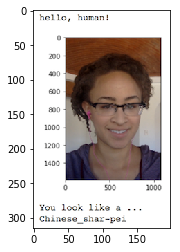

Hello, human!
You look like a... 
 English_toy_spaniel


In [33]:
filename = gui_fname()
predict_image(filename)

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ Yes it is what I expect. It idenfied correcty the man with mouth tattoe and a baby as human and the face with no eyes as unknown. It failed to identify one dog when mixed with larger percentage of text in an image. Possible points of improvement.
1. Use one algorithm instead of three to identify what image image and dog breed is in the photo.
2. Identify the region where the dog is located and ignore other areas for better result.
3. Apply image augmentation to improve accuracy.

In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

Image file selected: 


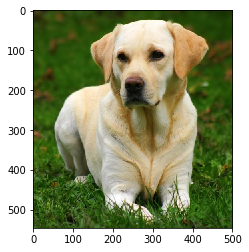

The dog breed is: Labrador_retriever


In [34]:
filename = gui_fname()
predict_image(filename)

Image file selected: 


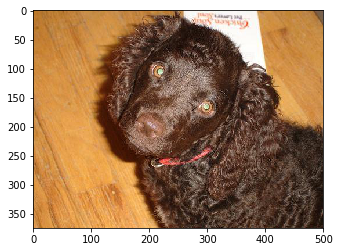

The dog breed is: American_water_spaniel


In [35]:
filename = gui_fname()
predict_image(filename)

Image file selected: 


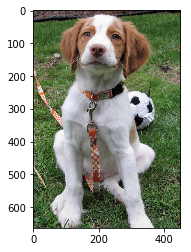

The dog breed is: Brittany


In [36]:
filename = gui_fname()
predict_image(filename)

Image file selected: 


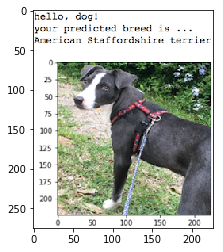

Error: Unknown Image


In [37]:
filename = gui_fname()
predict_image(filename)

Image file selected: 


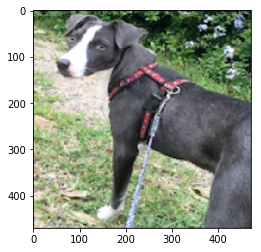

The dog breed is: Greyhound


In [38]:
filename = gui_fname()
predict_image(filename)

Image file selected: 


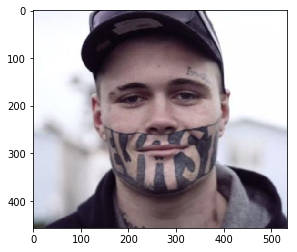

Hello, human!
You look like a... 
 Doberman_pinscher


In [39]:
filename = gui_fname()
predict_image(filename)

Image file selected: 


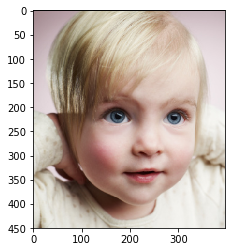

Hello, human!
You look like a... 
 Beagle


In [40]:
filename = gui_fname()
predict_image(filename)

Image file selected: 


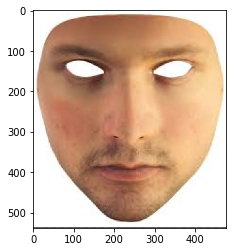

Error: Unknown Image


In [41]:
filename = gui_fname()
predict_image(filename)